In [1]:
import requests
import urllib
from bs4 import BeautifulSoup
import time
import re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
import asyncio
import aiohttp
import os
import time
from aiohttp import ClientSession
import nest_asyncio
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nest_asyncio.apply()
headers = {'Accept-Language': 'en',
          'X-FORWARDED-FOR': '2.21.184.0'}

            
def get_movies_by_actor_url(actor_page_url, num_of_movies_limit = None):
    while True:
        response = requests.get(actor_page_url, headers = headers)
        if response.status_code == 503:
            print("Error in request: 503. Trying again in 60 sec")
            time.sleep(60)
            continue
        break
    soup = BeautifulSoup(response.text)
    return get_movies_by_actor_soup(soup, num_of_movies_limit)

def get_actors_by_movie_url(movie_page_url, num_of_actors_limit = None):
    cast_page_url = movie_page_url + 'fullcredits'
    response = requests.get(url = cast_page_url, headers = headers)
    soup = BeautifulSoup(response.text)
    return get_actors_by_movie_soup(soup, num_of_actors_limit)


top_paid_actors = {
    'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005/',
    'Chris Hemsworth': 'https://www.imdb.com/name/nm1165110/',
    'Robert Downey Jr': 'https://www.imdb.com/name/nm0000375/',
    'Akshay Kumar': 'https://www.imdb.com/name/nm0474774/',
    'Jackie Chan': 'https://www.imdb.com/name/nm0000329',
    'Bradley Cooper': 'https://www.imdb.com/name/nm0177896/',
    'Adam Sandler': 'https://www.imdb.com/name/nm0001191/',
    'Scarlett Johansson': 'https://www.imdb.com/name/nm0424060/',
    'Sofia Vergara': 'https://www.imdb.com/name/nm0005527/',
    'Chris Evans': 'https://www.imdb.com/name/nm0262635'
    }

movie_distances = {
    ('Dwayne Johnson', 'Chris Hemsworth'): 2,
     ('Dwayne Johnson', 'Robert Downey Jr'): 2,
     ('Dwayne Johnson', 'Akshay Kumar'): float('inf'),
     ('Dwayne Johnson', 'Jackie Chan'): 3,
     ('Dwayne Johnson', 'Bradley Cooper'): 3,
     ('Dwayne Johnson', 'Adam Sandler'): 3,
     ('Dwayne Johnson', 'Scarlett Johansson'): 2,
     ('Dwayne Johnson', 'Sofia Vergara'): float('inf'),
     ('Dwayne Johnson', 'Chris Evans'): 2,
     ('Chris Hemsworth', 'Robert Downey Jr'): 1,
     ('Chris Hemsworth', 'Akshay Kumar'): 3,
     ('Chris Hemsworth', 'Jackie Chan'): float('inf'),
     ('Chris Hemsworth', 'Bradley Cooper'): 3,
     ('Chris Hemsworth', 'Adam Sandler'): 3,
     ('Chris Hemsworth', 'Scarlett Johansson'): 1,
     ('Chris Hemsworth', 'Sofia Vergara'): 3,
     ('Chris Hemsworth', 'Chris Evans'): 1,
     ('Robert Downey Jr', 'Akshay Kumar'): float('inf'),
     ('Robert Downey Jr', 'Jackie Chan'): float('inf'),
     ('Robert Downey Jr', 'Bradley Cooper'): float('inf'),
     ('Robert Downey Jr', 'Adam Sandler'): float('inf'),
     ('Robert Downey Jr', 'Scarlett Johansson'): 1,
     ('Robert Downey Jr', 'Sofia Vergara'): 3,
     ('Robert Downey Jr', 'Chris Evans'): 1,
     ('Akshay Kumar', 'Jackie Chan'): float('inf'),
     ('Akshay Kumar', 'Bradley Cooper'): float('inf'),
     ('Akshay Kumar', 'Adam Sandler'): float('inf'),
     ('Akshay Kumar', 'Scarlett Johansson'): float('inf'),
     ('Akshay Kumar', 'Sofia Vergara'): float('inf'),
     ('Akshay Kumar', 'Chris Evans'): float('inf'),
     ('Jackie Chan', 'Bradley Cooper'): float('inf'),
     ('Jackie Chan', 'Adam Sandler'): float('inf'),
     ('Jackie Chan', 'Scarlett Johansson'): float('inf'),
     ('Jackie Chan', 'Sofia Vergara'): float('inf'),
     ('Jackie Chan', 'Chris Evans'): float('inf'),
     ('Bradley Cooper', 'Adam Sandler'): float('inf'),
     ('Bradley Cooper', 'Scarlett Johansson'): 3,
     ('Bradley Cooper', 'Sofia Vergara'): float('inf'),
     ('Bradley Cooper', 'Chris Evans'): 3,
     ('Adam Sandler', 'Scarlett Johansson'): float('inf'),
     ('Adam Sandler', 'Sofia Vergara'): float('inf'),
     ('Adam Sandler', 'Chris Evans'): float('inf'),
     ('Scarlett Johansson', 'Sofia Vergara'): float('inf'),
     ('Scarlett Johansson', 'Chris Evans'): 1,
     ('Sofia Vergara', 'Chris Evans'): float('inf')
}

stop_words = {
    'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because',
      'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can','couldn', "couldn't", 'd', 'did','didn', "didn't", 'do', 'does', 'doesn',
      "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have',
      'haven', "haven't", 'having','he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it',
       "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no',
       'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over',
      'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the',
       'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very',
      'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn',
       "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves', ')', '(' ',' '.'
}

def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit = None):
    url = 'https://www.imdb.com/'

    rows = cast_page_soup.find_all('tr', attrs = {'class': ['odd','even']})
    actors = []
    for row in rows:
        actor_name = row.find_all('a')[1].getText().strip()
        actor_page = urllib.parse.urljoin(url, row.find_all('a')[1]['href'])
        actors.append((actor_name, actor_page))
    
    if num_of_actors_limit is None:
        return actors
    else:
        return actors[0:num_of_actors_limit]


def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit = None):
    url = 'https://www.imdb.com/'
    
    films = actor_page_soup.find_all('div', attrs={'class': ['filmo-row odd', 'filmo-row even'], 'id': re.compile(r'actor|actress')})
    films_list = []
    for film in films:
        if not film.getText().find(")") != -1:
            movie_name = film.find('a').getText()
            movie_page = urllib.parse.urljoin(url, film.find('a')['href'])
            films_list.append((movie_name, movie_page))
            
    if num_of_movies_limit is None:
        return films_list
    else:
        return films_list[0:num_of_movies_limit]


async def get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None):
    start = time.time()
    print(f'actor_url: {actor_start_url}')
    movies = get_movies_by_actor_url(actor_start_url,5)
    depth = 1
    checked_movies = set()
    checked_actors = set()

    while True:
        if depth > 3:
            print("No Success")
            return float('inf')
        print(f"Current Depth:{depth}")
        new_movies = []
        movies_url = [pair[1] for pair in movies]

        async def get_movie_response(movie_url, session):
            while True:
                response = await session.request(method='GET', url=movie_url+'fullcredits', headers = headers)
                if response.status == 503:
                    print("Error 503, trying again after timeout")
                    await asyncio.sleep(60)
                    continue
                break
            #print(f"Response status ({movie_url}): {response.status}")
            response_text = await response.text()
            return response_text

        async def collect_movies(movie_url, session):
            """Wrapper for running program in an asynchronous manner"""
            try:
                response_text = await get_movie_response(movie_url, session)
                return response_text
            except Exception as err:
                print(f"Exception occured: {err}")
                pass

        async with ClientSession() as session:
            movie_response_texts = await asyncio.gather(*[collect_movies(movie_url, session) for movie_url in movies_url])



        for m, (movie_name, movie_url) in enumerate(movies):
            print(f"\t Movie:{movie_name}")

            movie_soup = BeautifulSoup(movie_response_texts[m])
            actors_list = get_actors_by_movie_soup(movie_soup, num_of_actors_limit)
            actors_url = [pair[1] for pair in actors_list]

            async def get_actor_response(actor_url, session):
                while True:
                    response = await session.request(method='GET', url=actor_url, headers = headers)
                    if response.status == 503:
                        print("Error 503, trying again after timeout")
                        await asyncio.sleep(60)
                        continue
                    break
                #print(f"Response status ({actor_url}): {response.status}")
                response_text = await response.text()
                return response_text

            async def collect_actors(actor_url, session):
                """Wrapper for running program in an asynchronous manner"""
                try:
                    response_text = await get_actor_response(actor_url, session)
                    return response_text
                except Exception as err:
                    print(f"Exception occured: {err}")
                    pass

            async with ClientSession() as session:
                actors_response_texts = await asyncio.gather(*[collect_actors(actor_url, session) for actor_url in actors_url])



            for a, (actor_name, actor_url) in enumerate(actors_list):
                print(f"\t\t Actor:{actor_name}")
                if actor_url.strip("/") == actor_end_url.strip("/"):
                    print("Distance Found!")
                    print(f"Elapsed Time:{time.time()-start}")
                    return depth
                elif actor_url not in checked_actors:
                    actor_soup = BeautifulSoup(actors_response_texts[a])
                    new_movies += get_movies_by_actor_soup(actor_soup, num_of_actors_limit)
                    checked_actors.add(actor_url)
            checked_movies.add(movie_url)
        
        
        new_movies_set = set()
        for (movie_name, movie_url) in new_movies:
            new_movies_set.add((movie_name, movie_url))
        
        movies = new_movies_set - checked_movies
        depth += 1
        
async def get_movie_distances_for_top_actors():
    movie_distances = dict()
    top_paid_actors_list = list(top_paid_actors.items())
    for i in range(0, len(top_paid_actors_list)):
        for j in range(i+1, len(top_paid_actors_list)):
            print(top_paid_actors_list[i][0], top_paid_actors_list[j][0])
            distance = await get_movie_distance(top_paid_actors_list[i][1], top_paid_actors_list[j][1],5,5)
            movie_distances[(top_paid_actors_list[i][0], top_paid_actors_list[j][0])] = distance
    return movie_distances



def get_movie_descriptions_by_actor_soup(actor_page_soup):
    movies = get_movies_by_actor_soup(actor_page_soup)
    movie_descriptions = []
    for movie in movies:
        print(f"\t Movie name: {movie[0]}")
        try:
            response = requests.get(url=movie[1], headers = headers)
            soup = BeautifulSoup(response.text)
            movie_description = soup.find('div', attrs={'class': 'ipc-html-content ipc-html-content--base'}).find('div').text
            movie_descriptions.append(movie_description)
        except:
            print("Cannot parse this movie")
    return movie_descriptions

def plot_network(movie_distances, shown_distances = None):
    G = nx.Graph()
    
    if shown_distances:
        for k,v in movie_distances.items():
            node1 = k[0]
            node2 = k[1]
            weight = v
            if weight != shown_distances:
                continue
            G.add_edge(node1, node2, weight=weight)
    else:
        for k,v in movie_distances.items():
            node1 = k[0]
            node2 = k[1]
            weight = v
            if weight > 3:
                continue
            G.add_edge(node1, node2, weight=weight)

    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 3]
    emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color = 'b')
    nx.draw_networkx_edges(G, pos, edgelist=emedium, width=1, edge_color = 'y')
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="g", style="dashed"
    )

    # labels
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=8)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")


    ax = plt.gca()
    ax.margins(0.08)
    #plt.axis("off")
    plt.tight_layout()
    plt.show()
    
def save_movie_descriptions_to_file():
    for actor_name, actor_url in top_paid_actors.items():
        print(f"Actor name: {actor_name}")
        actor_page_soup = BeautifulSoup(requests.get(url=actor_url, headers=headers).text)
        movie_descriptions = get_movie_descriptions_by_actor_soup(actor_page_soup)
        text = " ".join(movie_descriptions)
        #print(text)
        with open(actor_name+'.txt', 'w', encoding='utf-8') as f:
            f.write(text)
            
def read_movie_distances(filename):
    new_dict = dict()
    with open(filename, "r", newline="") as f:
        while True:
            line = f.readline()
            if line == '':
                break
            row = line.split(',')
            new_dict[(row[0], row[1])] = float(row[2])
    return new_dict
            
    

def draw_workcloud(movie_description_file):
    with open(movie_description_file, 'r', encoding='utf-8') as f:
        text = f.read()
        word_tokens = text.split()
        filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
        # Start with one review:
        full_filtered_text = " ".join(filtered_text)
        # Create and generate a word cloud image:
        wordcloud = WordCloud().generate(full_filtered_text)

        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        

In [2]:
'''This function took several hours to complete, so I saved values to dict and loaded it right away. 
    This function call is to demonstrate how I collected the data.'''

await get_movie_distances_for_top_actors()

Dwayne Johnson Chris Hemsworth
actor_url: https://www.imdb.com/name/nm0425005/
Current Depth:1
	 Movie:Jungle Cruise
		 Actor:Dwayne Johnson
		 Actor:Emily Blunt
		 Actor:Edgar Ramírez
		 Actor:Jack Whitehall
		 Actor:Jesse Plemons
	 Movie:Jumanji: The Next Level
		 Actor:Dwayne Johnson
		 Actor:Kevin Hart
		 Actor:Jack Black
		 Actor:Karen Gillan
		 Actor:Awkwafina
	 Movie:Fast & Furious Presents: Hobbs & Shaw
		 Actor:Dwayne Johnson
		 Actor:Jason Statham
		 Actor:Idris Elba
		 Actor:Vanessa Kirby
		 Actor:Helen Mirren
	 Movie:Skyscraper
		 Actor:Dwayne Johnson
		 Actor:Neve Campbell
		 Actor:Chin Han
		 Actor:Roland Møller
		 Actor:Noah Taylor
	 Movie:Rampage
		 Actor:Dwayne Johnson
		 Actor:Naomie Harris
		 Actor:Malin Akerman
		 Actor:Jeffrey Dean Morgan
		 Actor:Jake Lacy
Current Depth:2
	 Movie:Jumanji: The Next Level
		 Actor:Dwayne Johnson
		 Actor:Kevin Hart
		 Actor:Jack Black
		 Actor:Karen Gillan
		 Actor:Awkwafina
	 Movie:Jungle Cruise
		 Actor:Dwayne Johnson
		 Actor:Emi

CancelledError: 

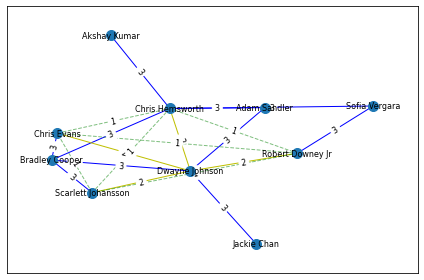

In [3]:
plot_network(movie_distances)

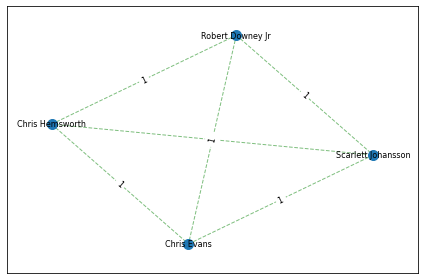

In [4]:
plot_network(movie_distances, shown_distances=1)

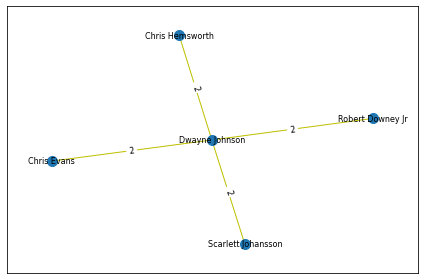

In [5]:
plot_network(movie_distances, shown_distances=2)

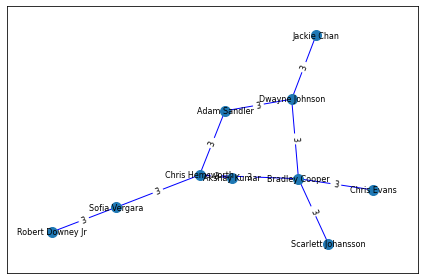

In [6]:
plot_network(movie_distances, shown_distances=3)

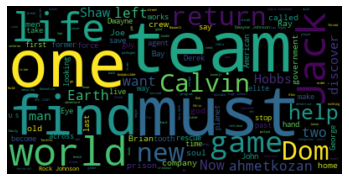

In [7]:
draw_workcloud('Dwayne Johnson.txt')

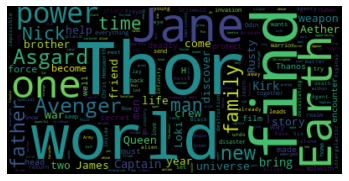

In [8]:
draw_workcloud('Chris Hemsworth.txt')

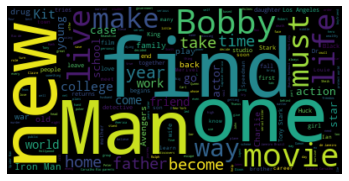

In [9]:
draw_workcloud('Robert Downey Jr.txt')

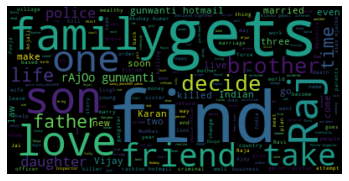

In [10]:
draw_workcloud('Akshay Kumar.txt')

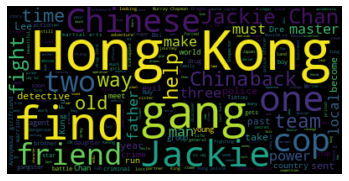

In [11]:
draw_workcloud('Jackie Chan.txt')

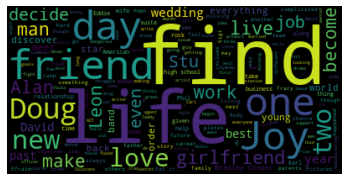

In [12]:
draw_workcloud('Bradley Cooper.txt')

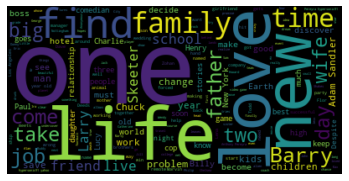

In [13]:
draw_workcloud('Adam Sandler.txt')

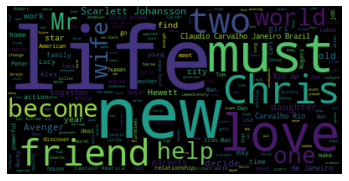

In [14]:
draw_workcloud('Scarlett Johansson.txt')

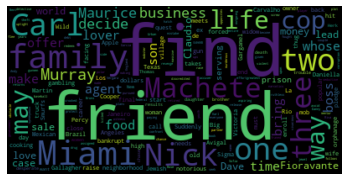

In [15]:
draw_workcloud('Sofia Vergara.txt')

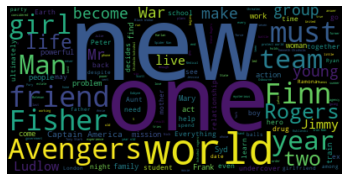

In [16]:
draw_workcloud('Chris Evans.txt')

In [17]:
read_movie_distances('movie_distances.csv')

{('Dwayne Johnson', 'Chris Hemsworth'): 2.0,
 ('Dwayne Johnson', 'Robert Downey Jr'): 2.0,
 ('Dwayne Johnson', 'Akshay Kumar'): inf,
 ('Dwayne Johnson', 'Jackie Chan'): 3.0,
 ('Dwayne Johnson', 'Bradley Cooper'): 3.0,
 ('Dwayne Johnson', 'Adam Sandler'): 3.0,
 ('Dwayne Johnson', 'Scarlett Johansson'): 2.0,
 ('Dwayne Johnson', 'Sofia Vergara'): inf,
 ('Dwayne Johnson', 'Chris Evans'): 2.0,
 ('Chris Hemsworth', 'Robert Downey Jr'): 1.0,
 ('Chris Hemsworth', 'Akshay Kumar'): 3.0,
 ('Chris Hemsworth', 'Jackie Chan'): inf,
 ('Chris Hemsworth', 'Bradley Cooper'): 3.0,
 ('Chris Hemsworth', 'Adam Sandler'): 3.0,
 ('Chris Hemsworth', 'Scarlett Johansson'): 1.0,
 ('Chris Hemsworth', 'Sofia Vergara'): 3.0,
 ('Chris Hemsworth', 'Chris Evans'): 1.0,
 ('Robert Downey Jr', 'Akshay Kumar'): inf,
 ('Robert Downey Jr', 'Jackie Chan'): inf,
 ('Robert Downey Jr', 'Bradley Cooper'): inf,
 ('Robert Downey Jr', 'Adam Sandler'): inf,
 ('Robert Downey Jr', 'Scarlett Johansson'): 1.0,
 ('Robert Downey Jr', 'Sof